In [3]:
import numpy as np 
from matplotlib import pyplot as plt
import math

In [312]:
def rand_row(n, prop_b):
    return ((np.random.random(n) < prop_b) * 1).tolist()

def rand_rule(neighbors):
    n = pow(2, neighbors)
    return rand_row(n, .5)

def next_row(row, rule):
    neighbors = int(math.log2(len(rule)))
    rang = math.trunc(neighbors / 2)
    next_row = []
    for i in range(len(row)):
        definition = ""
        for n in range(neighbors):
            definition = definition + str(row[(i+n-rang) % (len(row))])
        next_row.append(rule[int(definition, 2)])

    return next_row

def row_iterations(row, rule, N, show = False):
    matrix = [row]
    new_row = row
    for i in range(N):
        new_row = next_row(new_row, rule)
        matrix.append(new_row)

    matrix = np.array(matrix).astype(np.float)

    if show:
        plt.imshow(matrix)
        plt.show()
    
    return matrix

def gen_map(dimension, perc_zero, rule, show = False):
    return row_iterations(rand_row(dimension,perc_zero), rule, dimension, show)

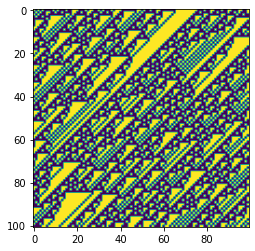

In [331]:
rule = rand_rule(3)
map = gen_map(dimension = 100, perc_zero = .5, rule = rule, show = True)